## Chest X-Ray Images (Pneumonia)

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

C:\Users\31234\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 2.29G/2.29G [01:50<00:00, 22.3MB/s]

Extracting files...


Path to dataset files: C:\Users\31234\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


In [3]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import random
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
from torchvision import models
from sklearn.metrics import f1_score, precision_score, recall_score
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

In [7]:
def plot_class_distribution(data, title):
    classes = list(data.keys())
    counts = list(data.values())

    plt.figure(figsize=(6, 4))
    plt.bar(classes, counts, color=["blue", "orange"])
    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel("Número de Imagens")
    plt.show()

In [52]:
def train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device="cpu"
):
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_accuracy": [],
        "val_accuracy": [],
        "train_f1": [],
        "val_f1": [],
        "train_precision": [],
        "val_precision": [],
        "train_recall": [],
        "val_recall": [],
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_f1 = f1_score(all_labels, all_preds, average="weighted")
        train_precision = precision_score(all_labels, all_preds, average="weighted")
        train_recall = recall_score(all_labels, all_preds, average="weighted")
        train_accuracy = (
            torch.tensor(all_preds) == torch.tensor(all_labels)
        ).sum().item() / len(all_labels)

        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_accuracy)
        history["train_f1"].append(train_f1)
        history["train_precision"].append(train_precision)
        history["train_recall"].append(train_recall)

        model.eval()
        val_loss = 0.0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        val_loss = val_loss / len(val_loader)
        val_f1 = f1_score(all_val_labels, all_val_preds, average="weighted")
        val_precision = precision_score(
            all_val_labels, all_val_preds, average="weighted"
        )
        val_recall = recall_score(all_val_labels, all_val_preds, average="weighted")
        val_accuracy = (
            torch.tensor(all_val_preds) == torch.tensor(all_val_labels)
        ).sum().item() / len(all_val_labels)

        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_accuracy)
        history["val_f1"].append(val_f1)
        history["val_precision"].append(val_precision)
        history["val_recall"].append(val_recall)

        print(
            f"Train: Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1-score: {train_f1:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}"
        )
        print(
            f"Validation: Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1-score: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}"
        )
        print()

    return history

In [9]:
def evaluate_model_on_test(model, test_loader, criterion, device="cpu"):
    model.eval()

    test_loss = 0.0
    all_test_preds = []
    all_test_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_test_preds.extend(preds.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

    test_loss = test_loss / len(test_loader)
    test_f1 = f1_score(all_test_labels, all_test_preds, average="weighted")
    test_precision = precision_score(
        all_test_labels, all_test_preds, average="weighted"
    )
    test_recall = recall_score(all_test_labels, all_test_preds, average="weighted")
    test_accuracy = (
        torch.tensor(all_test_preds) == torch.tensor(all_test_labels)
    ).sum().item() / len(all_test_labels)

    print(
        f"Teste: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, F1-score: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}"
    )

    return test_loss, test_accuracy, test_f1, test_precision, test_recall

In [46]:
def plot_metrics(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    # Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 3, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(2, 3, 2)
    plt.plot(epochs, history["train_accuracy"], label="Train Accuracy")
    plt.plot(epochs, history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy")
    plt.legend()

    # F1-Score
    plt.subplot(2, 3, 3)
    plt.plot(epochs, history["train_f1"], label="Train F1-Score")
    plt.plot(epochs, history["val_f1"], label="Validation F1-Score")
    plt.title("F1-Score")
    plt.legend()

    # Precision
    plt.subplot(2, 3, 4)
    plt.plot(epochs, history["train_precision"], label="Train Precision")
    plt.plot(epochs, history["val_precision"], label="Validation Precision")
    plt.title("Precision")
    plt.legend()

    # Recall
    plt.subplot(2, 3, 5)
    plt.plot(epochs, history["train_recall"], label="Train Recall")
    plt.plot(epochs, history["val_recall"], label="Validation Recall")
    plt.title("Recall")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [11]:
def evaluate_and_plot_confusion_matrix(model, test_loader, device="cpu"):
    model.eval()
    all_test_preds = []
    all_test_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            all_test_preds.extend(preds.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_test_labels, all_test_preds)

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Normal", "Pneumonia"],
        yticklabels=["Normal", "Pneumonia"],
    )
    plt.title("Confusion Matrix - Test Set")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

In [12]:
def plot_confusion_matrix_validation(model, val_loader, device="cpu"):
    model.eval()
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_val_labels, all_val_preds)

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Normal", "Pneumonia"],
        yticklabels=["Normal", "Pneumonia"],
    )
    plt.title("Confusion Matrix - Validation Set")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

In [13]:
def show_images(dataset_dir, class_name, num_images=5):
    class_path = os.path.join(dataset_dir, class_name)
    images = os.listdir(class_path)[:num_images]

    plt.figure(figsize=(12, 6))
    for i, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(class_name)
        plt.axis("off")
    plt.show()

In [14]:
def plot_histogram_of_intensities(dataset_dir, class_name, num_images=5):
    class_path = os.path.join(dataset_dir, class_name)
    images = os.listdir(class_path)[:num_images]

    plt.figure(figsize=(10, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path).convert("L")
        img_np = np.array(img).flatten()

        plt.subplot(1, num_images, i + 1)
        plt.hist(img_np, bins=50, color="blue", alpha=0.7)
        plt.title(f"Histograma - {class_name} {i+1}")
        plt.xlabel("Valor de Pixel")
        plt.ylabel("Frequência")
    plt.tight_layout()
    plt.show()

In [20]:
chest_xray_dir = ".\chest_xray"
train_dir = os.path.join(chest_xray_dir, "train")
val_dir = os.path.join(chest_xray_dir, "val")
test_dir = os.path.join(chest_xray_dir, "test")
train_classes = os.listdir(train_dir)
val_classes = os.listdir(val_dir)
test_classes = os.listdir(test_dir)

In [22]:
print(f"Classes in training: {train_classes}")
print(f"Classes in validation: {val_classes}")
print(f"Classes in test: {test_classes}")

Classes in training: ['NORMAL', 'PNEUMONIA']
Classes in validation: ['NORMAL', 'PNEUMONIA']
Classes in test: ['NORMAL', 'PNEUMONIA']


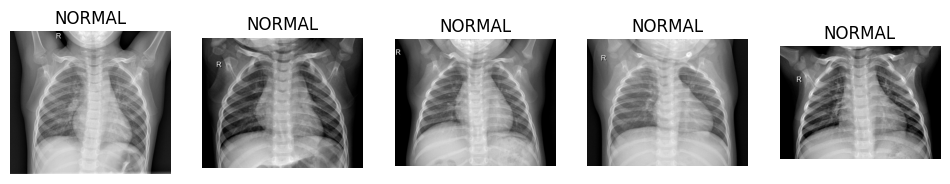

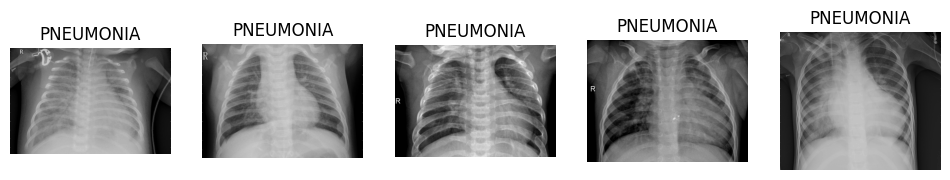

In [23]:
show_images(train_dir, "NORMAL", num_images=5)
show_images(train_dir, "PNEUMONIA", num_images=5)

In [37]:
# 设置原始文件夹路径和目标文件夹路径
src_folder = "./chest_xray"
dst_folder = os.path.join(src_folder, "mix")

# 定义目标分类文件夹的路径
normal_dst = os.path.join(dst_folder, "normal")
pneumonia_dst = os.path.join(dst_folder, "pneumonia")

# 创建 mix/normal 和 mix/pneumonia 文件夹（如果不存在）
os.makedirs(normal_dst, exist_ok=True)
os.makedirs(pneumonia_dst, exist_ok=True)

# 遍历 train、val 和 test 文件夹，将 normal 和 pneumonia 文件夹中的文件移动到目标文件夹中
for category in ["train", "val", "test"]:
    for label in ["normal", "pneumonia"]:
        src_path = os.path.join(src_folder, category, label)

    # 检查路径是否存在
        if os.path.exists(src_path):
            for filename in os.listdir(src_path):
                src_file = os.path.join(src_path, filename)

                # 将文件移动到 mix 的相应分类文件夹
                if label == "normal":
                    shutil.move(src_file, normal_dst)
                elif label == "pneumonia":
                    shutil.move(src_file, pneumonia_dst)

In [2]:
random.seed(42)
data_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
mix_dir = os.path.join(".\chest_xray",'mix')
mix_dataset = datasets.ImageFolder(mix_dir, transform=data_transforms)
train_size = int(0.8 * len(mix_dataset))
temp_size = len(mix_dataset) - train_size
train_subset, temp_subset = random_split(mix_dataset, [train_size, temp_size])

val_size, test_size = temp_size // 2, temp_size // 2
val_subset, test_subset = random_split(temp_subset, [val_size, test_size])

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

In [57]:
print(f"Training Size: {len(train_subset)}")
print(f"Validation Size: {len(val_subset)}")
print(f"Test Size: {len(test_subset)}")

Training Size: 4684
Validation Size: 586
Test Size: 586


### Model

In [66]:
class CustomDenseNet(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomDenseNet, self).__init__()

        # Load pre-trained DenseNet
        self.densenet = models.densenet121(pretrained=True)

        # Freeze the parameters of the DenseNet model
        for param in self.densenet.parameters():
            param.requires_grad = False

        # Number of features output by the DenseNet classifier
        num_ftrs = self.densenet.classifier.in_features

        # Define a custom classifier with BatchNorm
        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),  # Apply BatchNorm after ReLU + Dealing with gradient vanish
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),  # Apply BatchNorm after ReLU
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        # Extract features from DenseNet
        x = self.densenet.features(x)

        # Apply ReLU and BatchNorm after feature extraction
        x = nn.functional.relu(x, inplace=True)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)

        # Pass through the classifier
        x = self.classifier(x)
        return x

In [67]:
num_classes = 2
model = CustomDenseNet(num_classes)

C:\Users\31234\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\31234\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [68]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

torch.manual_seed(42)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
num_epochs = 10
history = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, device
)

Epoch 1/10
--------------------
Train: Loss: 0.2313, Accuracy: 0.9216, F1-score: 0.9229, Precision: 0.9260, Recall: 0.9216
Validation: Loss: 0.2551, Accuracy: 0.9130, F1-score: 0.9081, Precision: 0.9177, Recall: 0.9130

Epoch 2/10
--------------------
Train: Loss: 0.1391, Accuracy: 0.9528, F1-score: 0.9528, Precision: 0.9527, Recall: 0.9528
Validation: Loss: 0.1340, Accuracy: 0.9454, F1-score: 0.9447, Precision: 0.9450, Recall: 0.9454

Epoch 3/10
--------------------
Train: Loss: 0.1174, Accuracy: 0.9614, F1-score: 0.9613, Precision: 0.9613, Recall: 0.9614
Validation: Loss: 0.1485, Accuracy: 0.9369, F1-score: 0.9369, Precision: 0.9370, Recall: 0.9369

Epoch 4/10
--------------------
Train: Loss: 0.0990, Accuracy: 0.9658, F1-score: 0.9658, Precision: 0.9658, Recall: 0.9658
Validation: Loss: 0.1770, Accuracy: 0.9488, F1-score: 0.9486, Precision: 0.9485, Recall: 0.9488

Epoch 5/10
--------------------
Train: Loss: 0.0870, Accuracy: 0.9701, F1-score: 0.9701, Precision: 0.9700, Recall: 0.97

classifier.0.weight gradient mean: 0.0020209113135933876
classifier.0.bias gradient mean: 0.00045262498315423727
classifier.2.weight gradient mean: 0.003423083806410432
classifier.2.bias gradient mean: 0.005922558717429638
classifier.4.weight gradient mean: 0.002899408107623458
classifier.4.bias gradient mean: 0.0035204654559493065
classifier.6.weight gradient mean: 0.004887762013822794
classifier.6.bias gradient mean: 0.014029760845005512
classifier.7.weight gradient mean: 0.06442786008119583
classifier.7.bias gradient mean: 0.18930856883525848


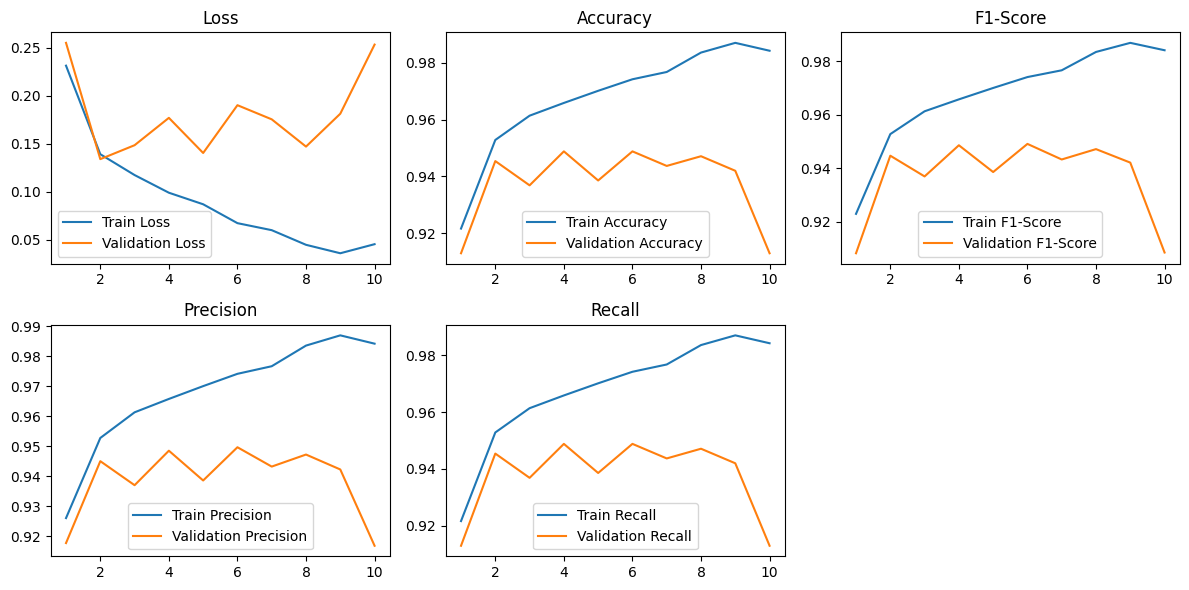

In [69]:
# check gradient vanish
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f"{name} gradient mean: {param.grad.abs().mean().item()}")

plot_metrics(history)

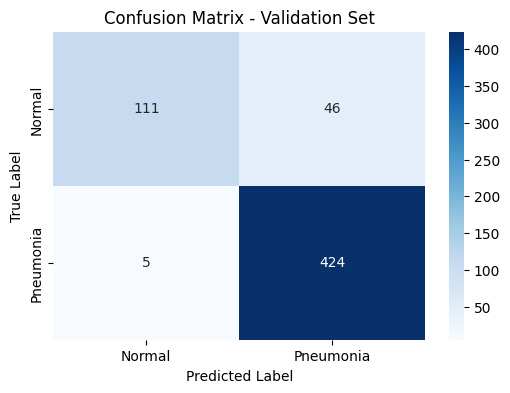

In [70]:
plot_confusion_matrix_validation(model, val_loader, device)

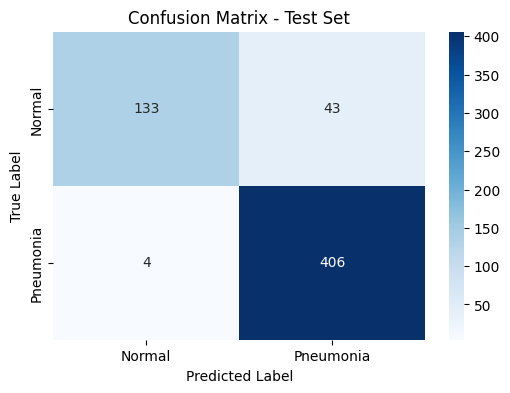

In [71]:
evaluate_and_plot_confusion_matrix(model, test_loader, device)